# This notebook produces the sentiment bar charts 


This notebook will perform the following steps:

1. Read in and process tweets
2. convert tweets into feature vectors
3. Converted tweets are fed into classifiers which then compute the sentiment of the tweets with probabilities
4. A threshold is selected, and tweets with a confidence below this threshold are classified as Neutral. Above this threshold, the sentiments are classified into positive or negative tweets.
5. All tweets are processed and the final graphs are generated


In [1]:
import warnings
import numpy as np

warnings.filterwarnings('ignore')

import os.path
import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion
from sklearn.feature_extraction.text import TfidfVectorizer

car_company = "Porche"

conn = sqlite3.connect('keyword_based_database.db')

q_ford='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%ford%'
AND LOWER(tweet_text) NOT LIKE '%harrison%'  
AND LOWER(tweet_text) NOT LIKE '%doug%'
AND LOWER(tweet_text) NOT LIKE '%tom%'
AND LOWER(tweet_text) NOT LIKE '%henry%'
AND LOWER(tweet_text) NOT LIKE '%government%'
AND LOWER(tweet_text) NOT LIKE '%goverment%'
AND LOWER(tweet_text) NOT LIKE '%tax%'
AND LOWER(tweet_text) NOT LIKE '%toronto%'
AND LOWER(tweet_text) NOT LIKE '%democrats%'
AND LOWER(tweet_text) NOT LIKE '%ontario%'
AND LOWER(tweet_text) NOT LIKE '%fordnation%'
AND LOWER(tweet_text) NOT LIKE '%premier%'
AND LOWER(tweet_text) NOT LIKE '%melissa%'
'''

q_toyota='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%toyota%'  
'''


q_mercedes='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%mercedes%'
'''

q_bmw='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%bmw%'  
AND LOWER(tweet_text) NOT LIKE '%police%'
LIMIT 10000;
'''

q_porche='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%porsche%'
AND LOWER(tweet_text) NOT LIKE '%davido%'
AND LOWER(tweet_text) NOT LIKE '%nuamah%'
AND LOWER(tweet_text) NOT LIKE '%actor%'
AND LOWER(tweet_text) NOT LIKE '%police%'
'''

q_tesla='''
SELECT * FROM tweet
WHERE LOWER(tweet_text) LIKE '%tesla%'
AND LOWER(tweet_text) LIKE '%model%'
AND LOWER(tweet_text) NOT LIKE '%elon%'
AND LOWER(tweet_text) NOT LIKE '%musk%'
AND LOWER(tweet_text) NOT LIKE '%solar roof%'
AND LOWER(tweet_text) NOT LIKE '%stock%'
AND LOWER(tweet_text) NOT LIKE '%production rate%'
AND LOWER(tweet_text) NOT LIKE '%money model%'
AND LOWER(tweet_text) NOT LIKE '%industry%'
AND LOWER(tweet_text) NOT LIKE '%net loss%'
AND LOWER(tweet_text) NOT LIKE '%loss%'
AND LOWER(tweet_text) NOT LIKE '%profit%'
AND LOWER(tweet_text) NOT LIKE '%atari%'
AND LOWER(tweet_text) NOT LIKE '%financial%'
AND LOWER(tweet_text) NOT LIKE '%earn%'
AND LOWER(tweet_text) NOT LIKE '%quarterly%'
AND LOWER(tweet_text) NOT LIKE '%record%'
AND LOWER(tweet_text) NOT LIKE '%market%'
AND LOWER(tweet_text) NOT LIKE '%outsell%'
AND LOWER(tweet_text) NOT LIKE '%produce%'
AND LOWER(tweet_text) NOT LIKE 'second-quarter'
AND LOWER(tweet_text) NOT LIKE 'invest'
'''

if(car_company=="Toyota"):
    q = q_toyota
elif(car_company=="Ford"):
    q= q_ford
elif(car_company=="Mercedes"):
    q=q_mercedes
elif(car_company=="BMW"):
    q=q_bmw
elif(car_company=="Porche"):
    q=q_porche
elif(car_company=="Tesla"):
    q=q_tesla


df = pd.read_sql_query(q,conn)

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Some simple data exploration on the filtered tweets, histograms of the tweet lengths

---------------------------------------------------------
Column names: 
 ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The number of tweets:  19257 

---------------------------------------------------------
Sample Tweets: 

0     RT @ABC: Lamborghini, Porsche and Mercedes Ben...
1     RT @Automotive_News: .@VW Group U.S. sales in ...
2     RT @erveza: Lamborghini, Porsche and Mercedes ...
3     RT @PorscheSauce: Nightlife ........\n\n#porsc...
4     My doctor literally has a canopy set up in his...
5     RT @PorscheRetail: The 'Hippie' 986 Boxster ta...
6     2019 Porsche 911 Caught Uncovered And Looking ...
7     RT @PorscheRetail: The 'Hippie' 986 Boxster ta...
8     RT @EpicDubs: 😍 those custom Cookie Cutters \n...
9     Hotness. New 2017 Porsche 718 Cayman S #porsch...
10    @ernie.garcia1 | Athens\n\n#xoluxury #xoluxury...
11    RT @PorscheSauce: Those lines.....\n\nPorsche ...
12    eBay: Boxster -- 1998 Porsche Boxster 

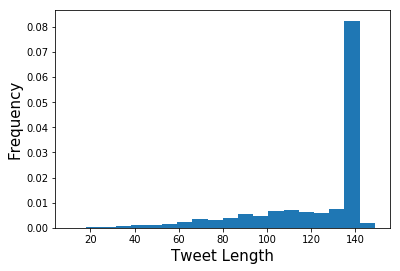

In [2]:
# Some simple Data exploration

N_raw_tweets = len(df)

print('---------------------------------------------------------')
print('Column names: \n', list(df.columns.values),"\n")
print('The number of tweets: ', N_raw_tweets,'\n')
print('---------------------------------------------------------')

# Show the First ten items in the tweet database
print("Sample Tweets: \n")
print(df['tweet_text'][0:100])



# A small data frame to plot the length of the tweets and plot a histogram
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_raw.pdf',bboxes='tight')
plt.show()

# Having loaded in the tweets we now process each tweet text and generate a histogram of the length of the processed tweets



The number of tweets after removing duplicates:  7514 

Fraction removed:  0.61


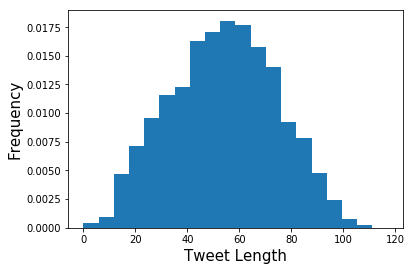

In [3]:
# Apply the 'Clean-up-text function to all tweets in the data frame'
df['tweet_text'] = df['tweet_text'].apply(clean_up_text)


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)

N_processed_tweets = len(df)

print('\n')
print('=============================================================')
print('The number of tweets after removing duplicates: ', N_processed_tweets ,'\n')
print('Fraction removed: ', round(1.0-(N_processed_tweets/float(N_raw_tweets)),3) )
print('=============================================================')

# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_processed.pdf',bboxes='tight')
plt.show()

In [4]:
import warnings
warnings.filterwarnings('ignore')

from process_text import clean_up_text
from process_text import string_cohesion
from textblob import TextBlob
import spacy
import pickle
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

#--------------------------------------------------------------
# Import the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
#--------------------------------------------------------------


#--------------------------------------------------------------
# Import the vocabulary and generate the vectorizer tranformer
#--------------------------------------------------------------
(A,terms,dict_sample) = joblib.load( "/home/javier/Documents/sentiment_analysis/sentiment_model/articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
print('number of terms: ',len(terms))#print(dic_sample[0:10])
print('Dictionary: ',len(dict_sample))

vectorizer = TfidfVectorizer(stop_words = custom_stop_words,min_df = 20)
A = vectorizer.fit_transform(dict_sample)
print('A: ', A.shape)
#--------------------------------------------------------------


#--------------------------------------------------------------
# We load the trained models
#--------------------------------------------------------------
# The names of the files containing the weights of the model
filename1 = 'lr_sentiment_model.sav'
filename2 = 'nb_sentiment_model.sav'

# Now we load in the trained models
loaded_lr = pickle.load(open(filename1, 'rb'))
loaded_nb = pickle.load(open(filename2, 'rb'))

Loaded 3500 X 2443 document-term matrix
number of terms:  2443
Dictionary:  8750
A:  (8750, 2443)


In [5]:
# Here we will define the final sentiment model


def sentiment_model(text,threshold):
    
    s = str(clean_up_text(text))
    
    X0 = vectorizer.transform([s])
    
    preds_nb = loaded_nb.predict(X0)
    preds_lr = loaded_lr.predict(X0)
    preds_blob =  TextBlob(text).sentiment.polarity
    
    if(preds_blob>=0.0):
        preds_blob = +1
    else:
        preds_blob = -1
        
    indx_nb= int((preds_nb[0]+1)/2)
    indx_lr= int((preds_lr[0]+1)/2)
    prob_nb = abs((loaded_nb.predict_proba(X0)[0][indx_nb]-.50)*2.0*int(preds_nb[0]))
    prob_lr = abs((loaded_lr.predict_proba(X0)[0][indx_lr]-0.50)*2.0*int(preds_lr[0]))
    prob_blob = abs(TextBlob(sample_text).sentiment.polarity) # [-1,1]
    
    
    if(prob_lr<threshold):
        preds_lr=[0.0]
        
    if(prob_nb<threshold):
        preds_nb=[0.0]
        
    if(prob_blob<threshold):
        preds_blob =0.0
        
        
    # choose the most likely model
    predictions = [preds_nb[0],preds_lr[0],preds_blob]
    predict_prob = [prob_nb,prob_lr,prob_blob]
    
    pred = predictions[np.argmax(predict_prob)]
    prob = np.max(predict_prob)
    
    
    return pred,prob

100%|██████████| 4/4 [03:00<00:00, 45.05s/it]


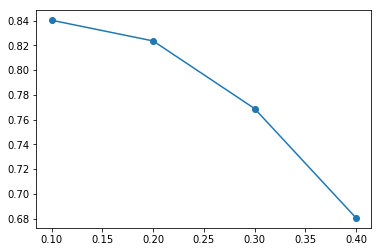

In [6]:
import collections
from tqdm import tqdm

thresholds = [0.1,0.2,0.3,0.4]
sentiment_pred = []
sentiment_prob = []
ratio = []

for threshold in tqdm(thresholds):
    
    sentiment_pred = []
    sentiment_prob = []
    
    for k in range(0,len(df)):
        sample_text = df['tweet_text'][k]
        pred,prob = sentiment_model(sample_text,threshold)
        sentiment_pred.append(pred)
        sentiment_prob.append(prob)
        
    m_count= collections.Counter(sentiment_pred)
    ratio.append(m_count[-1]/m_count[1])
    
plt.plot(thresholds,ratio,"-o")
plt.show()

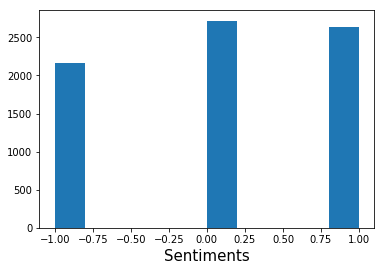

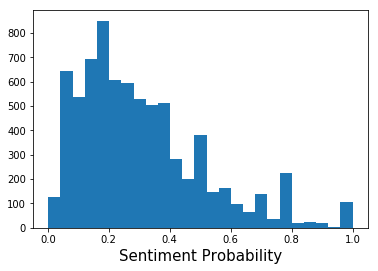

In [7]:
threshold = 0.2


sentiment_pred = []
sentiment_prob = []
    
for k in range(0,len(df)):
    sample_text = df['tweet_text'][k]
    pred,prob = sentiment_model(sample_text,threshold)
    sentiment_pred.append(pred)
    sentiment_prob.append(prob)

plt.hist(sentiment_pred)
plt.xlabel("Sentiments",size=15)
plt.show()


plt.hist(sentiment_prob,bins=25)
plt.xlabel("Sentiment Probability",size=15)
plt.show()

# Having selected the appropriate threshold for neutral comments, we compute the total number of positive and negative tweets

Total Sample:  7514
Neg/Pos ratio:  0.823574144486692


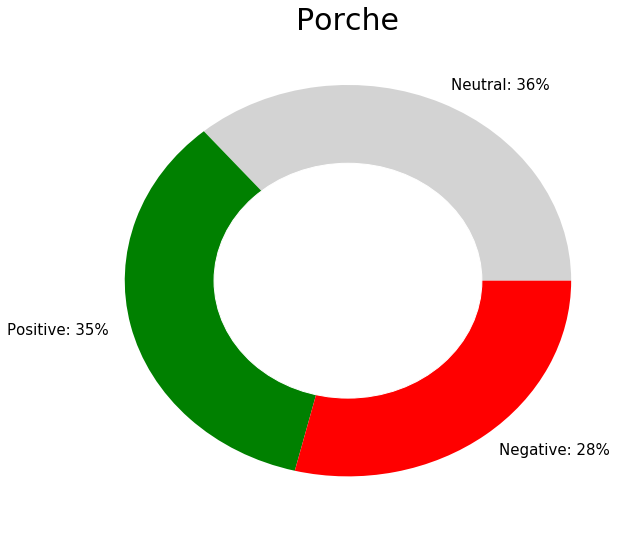

In [8]:
import matplotlib.pyplot as plt
import collections, numpy

matplotlib.rcParams['figure.figsize'] = 10, 9
matplotlib.rcParams['font.size'] = 15

# Count the various sentiments
m_count= collections.Counter(sentiment_pred)

size_model=[m_count[0],m_count[1],m_count[-1]]

# Compute the total numbers
total_number = np.sum(size_model)

# Compute the Percentages
percents = (np.asarray([m_count[0],m_count[1],m_count[-1]])/total_number)*100.0

print("Total Sample: ",total_number)
print("Neg/Pos ratio: ", m_count[-1]/m_count[1])
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.6, color='white')


# create data
names='Neutral: '+str(int(percents[0]))+"%",'Positive: '+str(int(percents[1]))+"%", 'Negative: '+str(int(percents[2]))+"%"

# Give color names
plt.title(car_company,size=30)
plt.pie(size_model, labels=names, colors=['lightgrey','green','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig(car_company+"_N_"+str(total_number)+".pdf",bboxes="tight")
plt.show()